<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/face-mask-detection/blob/main/Face%20Mask%20Detection%20MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Mask Detection**
Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur MobileNet.

In [1]:
!git clone https://github.com/Soedirman-Machine-Learning/face-mask-detection.git

Cloning into 'face-mask-detection'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3773 (delta 0), reused 4 (delta 0), pack-reused 3769
Receiving objects: 100% (3773/3773), 134.36 MiB | 42.22 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
# pindah ke filder face-mask-detection
%cd face-mask-detection/

/content/face-mask-detection


In [4]:
# memeriksa isi folder face-mask-detection
!ls

'berkas tugas akhir'   dataset	 face_detector	 README.md


In [5]:
!nvidia-smi

Tue Nov 10 20:13:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Memeriksa CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## Menghubungkan ke Google Drive
Langkah ini hanya untuk dataset pada Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


## Mengekstrak File face-mask-detector.zip
Lewati langkah ini jika tidak menggunakan Google Drive

In [5]:
project_path = '/content/MyDrive/My Drive/Colab Notebooks/Face-Mask-Detector-1/'
training_zip_path = project_path + 'face-mask-detection.zip'
from zipfile import ZipFile
 
with ZipFile(training_zip_path, 'r') as z:
  z.extractall()
print("Ekstrak Training Zip sudah selesai!")

Ekstrak Training Zip sudah selesai!


In [6]:
!ls

face-mask-detection  MyDrive  sample_data


### Pindah ke Folder Content

In [8]:
%cd /content/face-mask-detection

/content/face-mask-detection


### Menampilkan List Folder Content

In [9]:
!ls

dataset		      face_detector	   train_mask_detector.py
detect_mask_image.py  mask_detector.model
detect_mask_video.py  plot.png


## Mengimpor Libraries yang dibutuhkan

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

time: 175 µs


## Menampilkan Versi TensorFlow yang digunakan

In [8]:
print(tf.__version__)

2.3.0
time: 1.25 ms


## Preprocessing Datasets

In [10]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32
 
# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Sedang menginput gambar...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
# loop over the image paths
for imagePath in imagePaths:
 
    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
 
# mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Sedang menginput gambar...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


time: 15.3 s


### Membuat objek ImageDataGenerator dan Data Augmentation

In [11]:
# mempartisi data ke dalam pelatihan dan pengujian ( 75% : 25% )
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 685 ms


## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)

In [12]:
# Arsitektur jaringan MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step
time: 6.73 s


### Feature Extraction

In [13]:
baseModel.trainable = False
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## Membuat Model Arsitektur CNN

In [14]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
 
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
 
# Kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
model.summary()
 

Mengkompilasi model...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________________________________________________

### Melakukan Pelatihan Model

In [15]:
# train the head of the network
print("Training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head...
Epoch 1/10
95/95 [==============================] - 32s 332ms/step - loss: 0.2905 - accuracy: 0.8734 - val_loss: 0.0916 - val_accuracy: 0.9661
Epoch 2/10
95/95 [==============================] - 31s 329ms/step - loss: 0.0958 - accuracy: 0.9680 - val_loss: 0.0654 - val_accuracy: 0.9739
Epoch 3/10
95/95 [==============================] - 31s 322ms/step - loss: 0.0801 - accuracy: 0.9743 - val_loss: 0.0505 - val_accuracy: 0.9791
Epoch 4/10
95/95 [==============================] - 31s 323ms/step - loss: 0.0695 - accuracy: 0.9786 - val_loss: 0.0456 - val_accuracy: 0.9804
Epoch 5/10
95/95 [==============================] - 30s 321ms/step - loss: 0.0565 - accuracy: 0.9799 - val_loss: 0.0420 - val_accuracy: 0.9844
Epoch 6/10
95/95 [==============================] - 31s 322ms/step - loss: 0.0479 - accuracy: 0.9822 - val_loss: 0.0348 - val_accuracy: 0.9831
Epoch 7/10
95/95 [==============================] - 30s 321ms/step - loss: 0.0417 - accuracy: 0.9862 - val_loss: 0.0335 - val

### Menampilkan Grafik Model Hasil Pelatihan

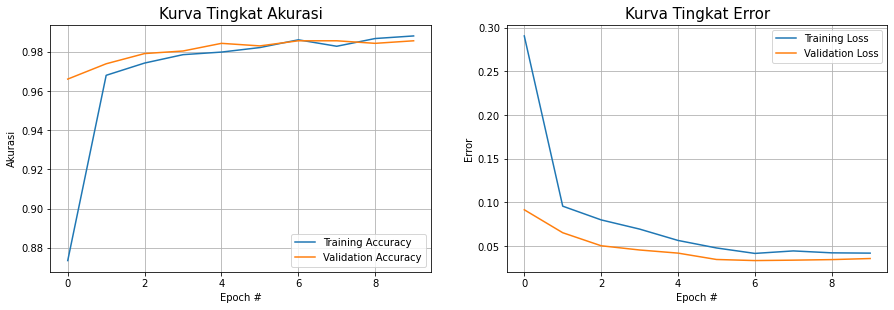

time: 308 ms


In [16]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Akurasi")
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

In [17]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4
time: 1.11 ms


### Evaluasi Jaringan

In [18]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)
 
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
 
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      1.00      0.99       383
without_mask       1.00      0.97      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

time: 1.65 s


## Menyimpan dan Konversi Model ke ".tflite"
Menyimpan model menggunakan tf.saved_model/save dan kemudian mengkonversi model tersimpan ke format yang kompatibel tf lite.

In [19]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Face_Mask_Detection_MobileNetV2.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
time: 22.3 s


## Penggunaan Model pada gambar

In [20]:
!ls

'berkas tugas akhir'   face_detector			        README.md
 dataset	       Face_Mask_Detection_MobileNetV2.tflite   save
time: 174 ms


In [ ]:
# USAGE
# python detect_mask_image.py --image examples/example_01.png
 
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
 
# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('/dataset/test/with_mask/mask15.jpg')
orig = image.copy()
(h, w) = image.shape[:2]
 
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
 
net=cv2.dnn.readNet('/face_detector/deploy.prototxt','/face_detector/res10_300x300_ssd_iter_140000.caffemodel')
 
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()
 
# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
 
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
 
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
 
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
 
        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
 
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
 
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

## Menguji Model Secara Realtime

In [ ]:
# USAGE
# python detect_mask_video.py
 
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
 
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
 
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
 
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
 
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
 
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
 
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
 
            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))
 
    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
 
    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)
 
faceNet=cv2.dnn.readNet('/face_detector/deploy.prototxt','/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

In [ ]:
import base64
import html
import io
import time
 
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
 
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [25]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

time: 3.49 ms


In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)

	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):


		# unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
      cv2_imshow(frame)